In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.

#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [2]:
df = pd.read_csv('user_transactions.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [3]:
df.head()

event_date             user_id   product  amount  transactions
0 2020-09-29   40746820883461494     basic    95.0             1
1 2020-09-29   41102328408008828  advanced   279.0             1
2 2020-09-29   63464894315144075     basic    64.0             1
3 2020-09-29  111526991873455341     basic   399.0             1
4 2020-09-29  169522572963414231     basic   199.0             1

In [4]:
df.tail()

event_date              user_id   product  amount  transactions
1278181 2020-12-29  9175681616034416929  advanced   679.0             1
1278182 2020-12-29  9190225485662720178  advanced   439.0             1
1278183 2020-12-29  9192452502210580022     basic   149.0             1
1278184 2020-12-29  9202424686732081420     basic   947.0             3
1278185 2020-12-29  9219633945080038962     basic    79.0             1

#### Средний чек

In [65]:
daily_avg_check = df.groupby('event_date').amount.sum() / df.groupby('event_date').transactions.sum()
quarter_avg_check = df.amount.sum() / df.transactions.sum()
print(f'Квартальный средний чек - {quarter_avg_check:.3f}')

Квартальный средний чек - 185.243


<AxesSubplot:>

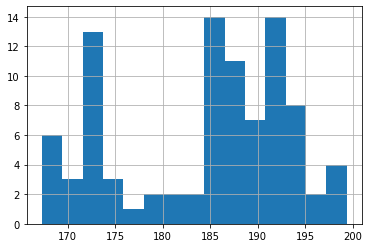

In [75]:
daily_avg_check.hist(bins=15)

In [34]:
first_month = [date_converter('2020-09-29'), date_converter('2020-10-29')]
second_month = [date_converter('2020-10-29'), date_converter('2020-11-29')]


def range_months(x):
    if x >= first_month[0] and x < first_month[1]:
        return 1
    elif x >= second_month[0] and x < second_month[1]:
        return 2
    else:
        return 3

In [36]:
df['month_rank'] = df.event_date.apply(range_months)
df.head()

event_date             user_id   product  amount  transactions  month_rank
0 2020-09-29   40746820883461494     basic    95.0             1           1
1 2020-09-29   41102328408008828  advanced   279.0             1           1
2 2020-09-29   63464894315144075     basic    64.0             1           1
3 2020-09-29  111526991873455341     basic   399.0             1           1
4 2020-09-29  169522572963414231     basic   199.0             1           1

#### Средний доход с пользователя за квартал

In [76]:
df.amount.sum() / df.user_id.nunique()

684.8350162775348

#### Транзакции по пользователям

In [77]:
user_transactions_by_user = df.groupby('user_id').transactions.sum()

In [78]:
user_transactions_by_user.describe()

count    446935.000000
mean          3.696954
std          16.522523
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3070.000000
Name: transactions, dtype: float64

In [79]:
user_transactions_by_user.quantile(q=0.99)

42.0

In [81]:
plt.figure(figsize=(15, 5))
user_transactions_by_user.plot.hist(bins=2500, xlim=(0, 42))

<AxesSubplot:ylabel='Frequency'>

75% пользователй совершило за 3 месяца не больше двух покупок. Также можно отметить, что некоторые пользователи совершали очень много транзакций, а 99 перцентиль равен 42, но при этом есть как минимум один пользователей, совершивший 3070 транзакций - сильный выброс

Посмотрим на число транзакций в каждом месяце:

In [60]:
df.groupby('month_rank').transactions.sum()

month_rank
1    489589
2    548473
3    614236
Name: transactions, dtype: int64

Видим, что к декабрю число транзакций заметно выросло

#### Средний чек пользователя

In [82]:
avg_check_by_user = df.groupby('user_id').amount.sum() / df.groupby('user_id').transactions.sum()

In [83]:
avg_check_by_user.describe()

count    446935.000000
mean        164.756601
std         159.857759
min           8.000000
25%          70.000000
50%         117.500000
75%         199.000000
max        1869.000000
dtype: float64

In [84]:
avg_check_by_user.quantile(q=0.99)

819.0

<AxesSubplot:ylabel='Frequency'>

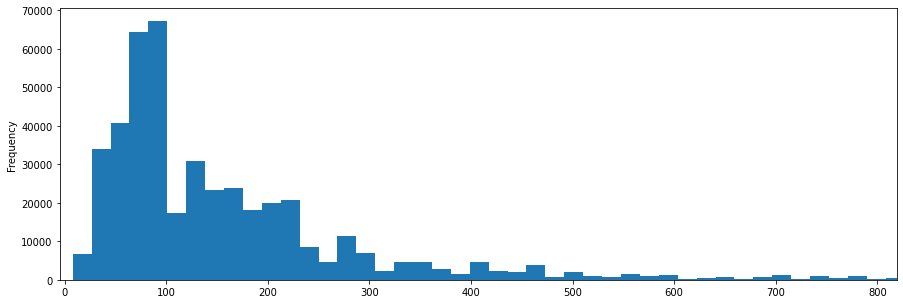

In [88]:
plt.figure(figsize=(15, 5))
avg_check_by_user.plot.hist(bins=100, xlim=(-5, 819))

Преимущественно пользователи тратили в пределах 500(99 перцентиль - 819). Но есть и пользователь, которой совершил одну или несколько очень дорогих транзакций c средним чеком - 1869

#### Формализация гипотез

- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
    
    Если гипотеза верна, то должно увеличится общее число транзакций и число транзакций с пользователя $\Rightarrow$ среднее число транзакций по пользователям вырастет. Предположил бы рост до 5-7 %
    
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

    Если гипотеза верна, то должно увеличится число покупок продвинутого продукта $\Rightarrow$ среднее число транзакций  для продвинутого продукта по пользователям вырастет. Но число транзакций на базовый продукт уменьшится, т.к. люди либо полностью откажутся, либо перейдут на продвинутый $\Rightarrow$ общее число транзакций скорее всего уменьшится

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала